In [1]:
import time
import torch
import random
import numpy as np
from torch import nn
from matplotlib import pyplot as plt
from torchvision.transforms import v2
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, Subset
from torchsummary import summary

In [2]:
transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((32, 32))
    ]
)

In [3]:
train_dataset = FashionMNIST(root='dataset/', train=True, transform=transforms, target_transform=transforms, download=True)
test_dataset = FashionMNIST(root='dataset/', train=False, transform=transforms, target_transform=transforms, download=True)

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.enc_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
        )
        self.enc_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
        )
        self.enc_3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
        )
        self.enc_4 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=2048, out_features=2)
        )

    def forward(self, x):
        x = self.enc_1(x)
        x = self.enc_2(x)
        x = self.enc_3(x)
        x = self.enc_4(x)
        
        return x

In [5]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.dec_1 = nn.Sequential(
            nn.Linear(in_features=2, out_features=2048),
            nn.Unflatten(dim=1, unflattened_size=(128, 4, 4))
        )
        self.dec_2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU()
        )
        self.dec_3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU()
        )
        self.dec_4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU()
        )
        self.dec_5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.dec_1(x)
        x = self.dec_2(x)
        x = self.dec_3(x)
        x = self.dec_4(x)
        x = self.dec_5(x)
        
        return x

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()

        self.ae_1 = encoder
        self.ae_2 = decoder

    def forward(self, x):
        x = self.ae_1(x)
        x = self.ae_2(x)
        
        return x

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

Using cuda


In [8]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)

model = Autoencoder(encoder, decoder).to(device)

In [9]:
summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             320
              ReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 64, 8, 8]          18,496
              ReLU-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
           Flatten-7                 [-1, 2048]               0
            Linear-8                    [-1, 2]           4,098
           Encoder-9                    [-1, 2]               0
           Linear-10                 [-1, 2048]           6,144
        Unflatten-11            [-1, 128, 4, 4]               0
  ConvTranspose2d-12            [-1, 128, 8, 8]         147,584
             ReLU-13            [-1, 128, 8, 8]               0
  ConvTranspose2d-14           [-1, 64,

In [10]:
learning_rate = 1e-3
batch_size = 512
start_epoch = 50
epochs = 100

In [11]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

def resume(model, filename):
    model.load_state_dict(torch.load(filename, weights_only=True))

In [14]:
# Copied from: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    
    for batch, (image, label) in enumerate(dataloader):
        i, l = image.to(device), label.to(device)
        preds = model(i)
        loss = loss_fn(preds, i)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss_fn(preds, i).item()
        
    train_loss /= num_batches    
    print(f"Avg. Train loss: {train_loss:>8f}")


# Copied from: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for batch, (image, label) in enumerate(dataloader):
            i, l = image.to(device), label.to(device)
            preds = model(i)
            test_loss += loss_fn(preds, i).item()
            
    test_loss /= num_batches
    print(f"Avg. Test loss: {test_loss:>8f}")

In [15]:
# Copied from: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
if start_epoch > 0:
    resume_epoch = start_epoch - 1
    resume(model, f"checkpoints/epoch-{resume_epoch}.pth")

for t in range(start_epoch, epochs):
    t0 = time.time()
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
    print(f"Epoch time: {time.time() - t0}\n")
    checkpoint(model, f"checkpoints/epoch-{t}.pth")
print("Done!")

Epoch 51
-------------------------------
Avg. Train loss: 0.334799
Avg. Test loss: 0.330288
Epoch time: 12.890890836715698

Epoch 52
-------------------------------
Avg. Train loss: 0.326447
Avg. Test loss: 0.330353
Epoch time: 12.740192413330078

Epoch 53
-------------------------------
Avg. Train loss: 0.326405
Avg. Test loss: 0.330491
Epoch time: 12.748077392578125

Epoch 54
-------------------------------
Avg. Train loss: 0.326402
Avg. Test loss: 0.330258
Epoch time: 12.654268026351929

Epoch 55
-------------------------------
Avg. Train loss: 0.326523
Avg. Test loss: 0.331038
Epoch time: 12.74898910522461

Epoch 56
-------------------------------
Avg. Train loss: 0.326408
Avg. Test loss: 0.330194
Epoch time: 12.663997888565063

Epoch 57
-------------------------------
Avg. Train loss: 0.326319
Avg. Test loss: 0.331293
Epoch time: 12.72364330291748

Epoch 58
-------------------------------
Avg. Train loss: 0.326273
Avg. Test loss: 0.331098
Epoch time: 12.691353559494019

Epoch 59
-

In [16]:
subset_indices = [random.randint(0, test_dataset.__len__() - 1) for i in range(10)]
data_subset = Subset(test_dataset, subset_indices)
data_subset_loader = DataLoader(data_subset, batch_size=1, shuffle=True)

In [17]:
def infer_and_plot_results(dataloader, model):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    with torch.no_grad():
        for batch, (image, label) in enumerate(dataloader):
            i, l = image.to(device), label.to(device)
            p = model(i)

            fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
            fig.supylabel(f'Test Output')
            fig.tight_layout()
            
            ax1.imshow(torch.permute(p[0], (1, 2, 0)).cpu().data.numpy(), cmap='gray')
            ax1.set_title('Prediction')
            ax2.imshow(torch.permute(i[0], (1, 2, 0)).cpu().data.numpy(), cmap='gray')
            ax2.set_title('Reference')

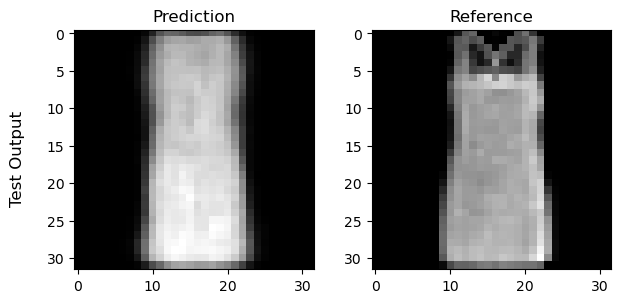

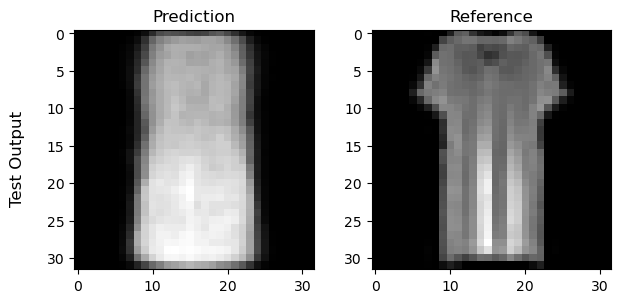

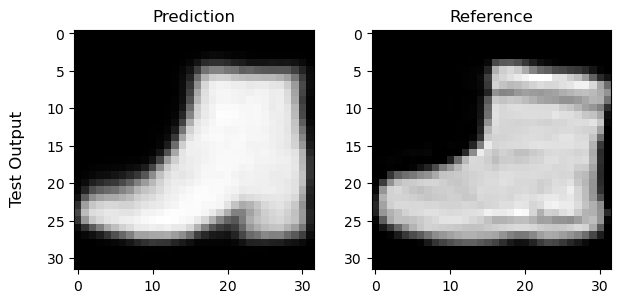

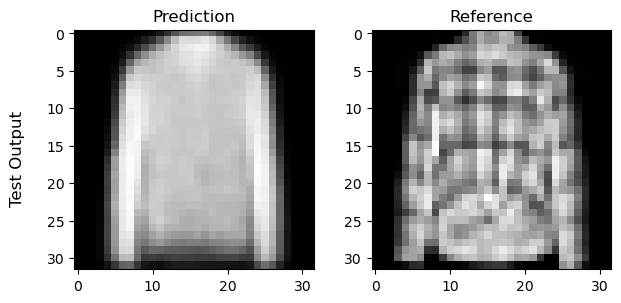

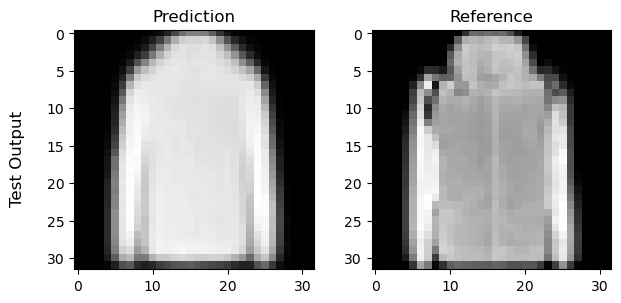

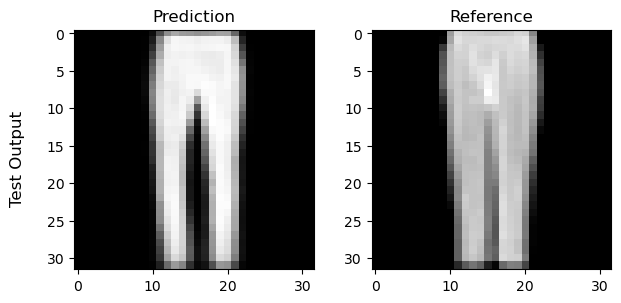

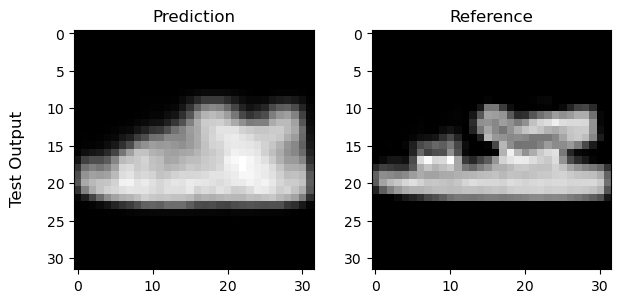

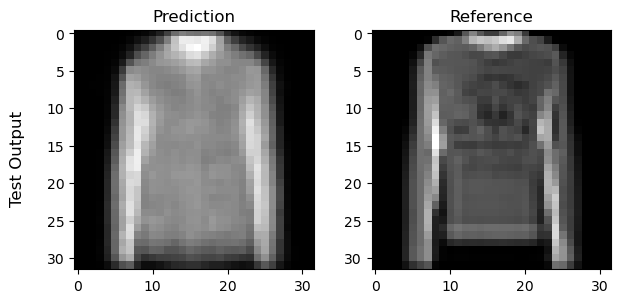

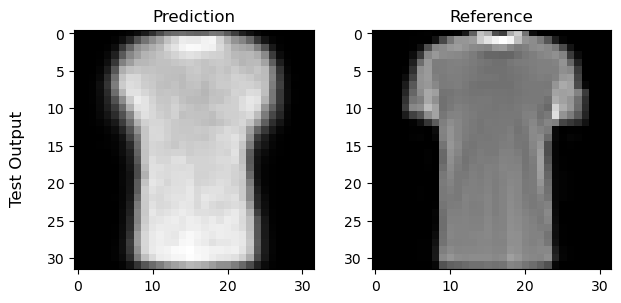

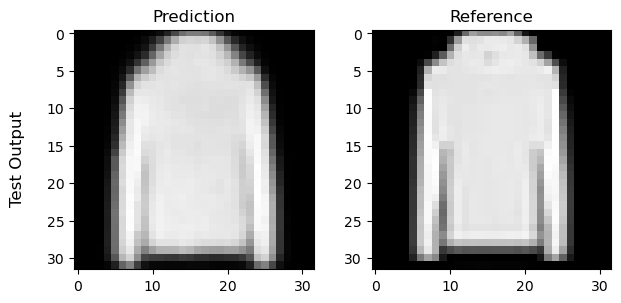

In [18]:
infer_and_plot_results(data_subset_loader, model)

In [19]:
def visualize_latent_space(encoder):
    embeddings = []
    
    for _, (i, _) in enumerate(test_dataloader):
        i = i.to(device)
        p = encoder(i)
        p = p.cpu().data.numpy()
        embeddings.append(p)

    embeddings = np.concatenate(embeddings)
    
    plt.figure(figsize=(8, 8))
    plt.scatter(x=embeddings[:, 0], y=embeddings[:, 1], s=1, alpha=0.5, c='black')
    plt.show()

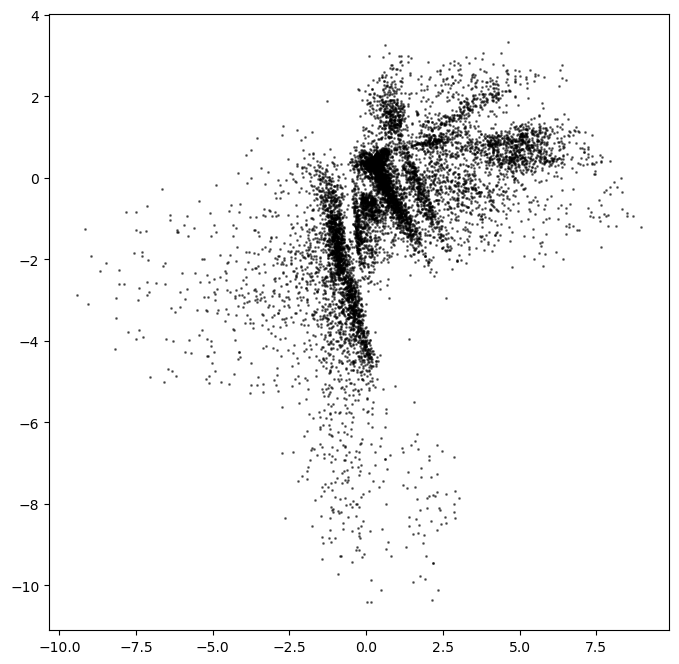

In [20]:
visualize_latent_space(encoder)

In [21]:
def decode_random_sample(decoder):
    embedding = (torch.abs(torch.randn((1, 2))) * 1).to(device)
   
    p = decoder(embedding)
    p = p[0].permute((1, 2, 0)).cpu().data.numpy()
    
    plt.figure(figsize=(8, 8))
    plt.imshow(p, cmap='gray')
    plt.show()

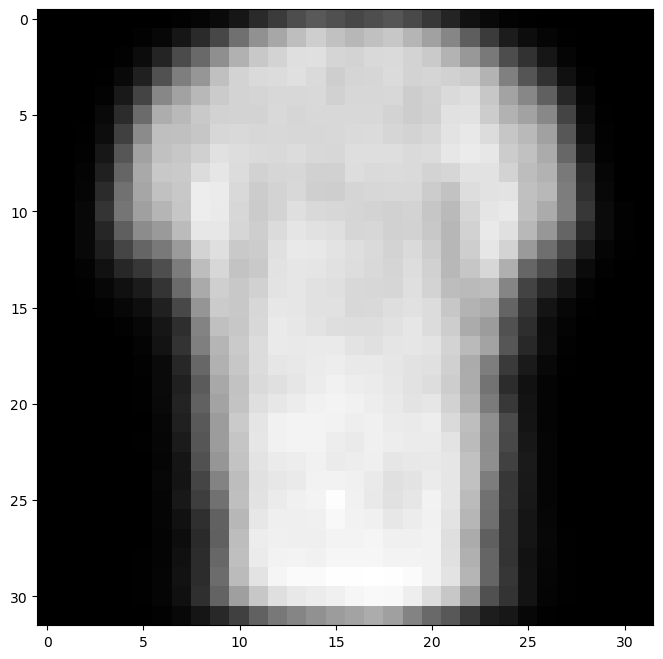

In [22]:
decode_random_sample(decoder)